In [133]:
%pip install opencv-python matplotlib numpy scikit-learn --quiet
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [25]:
# 1. Extract frames from video

def extractFrames(video_path, output_path, max_frame_count):
    """ 
    Extracts frames (images) from a video at `video_path` and writes them to `output_path`
    Stops extracting at `max_frame_count` if specified.
    """
    
    video = cv2.VideoCapture(video_path)
    success, img = video.read()

    count = 0
    while success and count < max_frame_count:
        count += 1
        cv2.imwrite(f"{output_path}/frame{count}.jpg", img)
        success, img = video.read()

    print(f"Extracted {count} frames!")

def wipeFolder(folder_path):
    """
    Removes all files in a folder. 
    Intended to be used to delete all frames extracted.
    """
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        os.remove(file_path)

VIDEOS_DIR_PATH = "videos/trimmed/"
FRAMES_DIR_PATH = "frames/"
TEST_VIDEO = "clair_de_lune.mp4"

# wipeFolder(FRAMES_DIR_PATH) # Use this to wipe "frames" folder
extractFrames(VIDEOS_DIR_PATH + TEST_VIDEO, FRAMES_DIR_PATH, 10)

Extracted 10 frames!


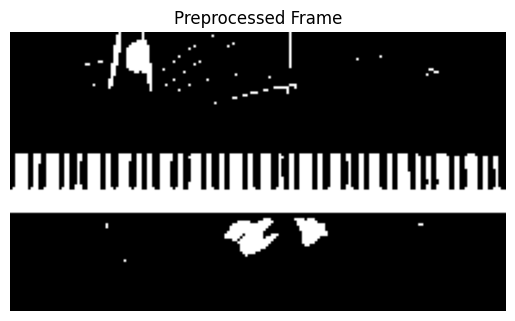

In [71]:
# 2. Frame Preprocessing

def preProcessFrame(frame_path, kernel_size=(5, 5), downsize_factor=10, binary_threshold=100, visualize=False, save_path=None):
    """
    Preprocesses a frame at `frame_path`, through the following steps:
        1. Convert to grayscale
        2. Blur with box filter, with `kernel_size`
        3. Downsize by `downsize_factor`
        4. Binarize. Pixels above `binary_threshold` is set to white (255), otherwise black (0).
    Returns the frame.
    Optionally, shows the final frame if `visualize` is to True, and saves it to `save_path` if specified.
    """
    # Load frame
    frame = cv2.imread(frame_path)
    if frame is None:
        print("Failed to read frame.")
        return

    # Convert to grayscale
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Blur
    frame_blur = cv2.blur(frame_gray, kernel_size)

    # Downsize
    new_width, new_height = frame_blur.shape[1] // 10, frame_blur.shape[0] // 10
    frame_small = cv2.resize(frame_blur, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Binarize
    _, frame_binary = cv2.threshold(frame_small, binary_threshold, 255, cv2.THRESH_BINARY)

    if visualize:
        plt.figure()
        plt.imshow(frame_binary, cmap="gray")
        plt.title("Preprocessed Frame")
        plt.axis('off')

    if save_path:
        cv2.imwrite(save_path, frame_binary)

    return frame_binary

TEST_FRAME = "frame3.jpg"
frame_preprocessed = preProcessFrame(FRAMES_DIR_PATH + TEST_FRAME, binary_threshold=80, visualize=True)

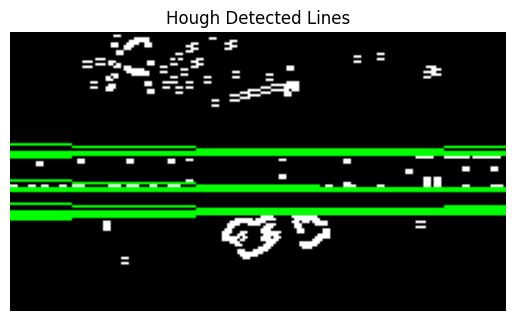

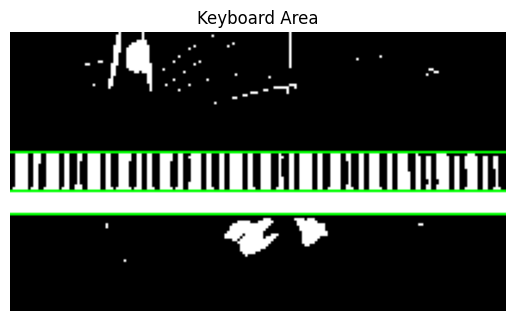

In [191]:
# 3. Keyboard Area Detection

# Scharr Operator implementation
HORIZ_SCHARR_KERNEL = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])
VERT_SCHARR_KERNEL = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])

def applyScharr(img, is_horiz, visualize=False):
    """
    Applies the Scharr operator to a grayscale `img` to find edges in one direction.
    Finds horizontal edges if `is_horiz` is set to True, otherwise vertical edges.
    Optionally visualizes the final result if `visualize` is set to True.
    """
    kernel = HORIZ_SCHARR_KERNEL if is_horiz else VERT_SCHARR_KERNEL
    result = cv2.convertScaleAbs(cv2.filter2D(img, cv2.CV_64F, kernel))

    if visualize:
        plt.figure()
        plt.imshow(result, cmap="gray")
        plt.title("Scharr Operator Result")
        plt.axis('off')

    return result

# Hough Transform implementation
def findHoughLines(img_edges, threshold=100, theta_min=-np.pi/2, theta_max=np.pi/2, theta_step=np.pi/180, rho_step=1, 
                   use_nms=True, nms_window_size=3,
                   visualize=False):
    # Initialize Hough space
    diag_length = np.sqrt(img_edges.shape[0] ** 2 + img_edges.shape[1] ** 2)
    rho_values = np.arange(-diag_length, diag_length, rho_step)
    theta_values = np.arange(theta_min, theta_max, theta_step)
    cos_values = np.cos(theta_values)
    sin_values = np.sin(theta_values)

    hough_space = np.zeros((len(rho_values), len(theta_values)))

    # Search Hough space by iterating over all edge pixels
    for height, width in zip(*np.where(img_edges > 0)):
        for theta_idx in range(len(theta_values)):
            rho = width * cos_values[theta_idx] + height * sin_values[theta_idx]
            closest_valid_rho_idx = np.argmin(abs(rho - rho_values))
            hough_space[closest_valid_rho_idx, theta_idx] += 1
    
    # Apply non-maximum suppression
    if use_nms:
        pad = nms_window_size // 2
        rows, cols = hough_space.shape
        for row in range(pad, rows - pad):
            for col in range(pad, cols - pad):
                window = hough_space[row - pad: row + pad + 1, col - pad: col + pad + 1]

                # Suppress vote if not maximum in window
                if hough_space[row, col] != np.max(window):
                    hough_space[row, col] = 0

    # Get polar coordinates of found lines
    rho_indices, theta_indices = np.where(hough_space > threshold)
    found_rho_values = rho_values[rho_indices]
    found_sin_values = sin_values[theta_indices]
    found_cos_values = cos_values[theta_indices]

    # Convert back to Cartesian coordinates and draw lines
    lines = []
    for rho, sin, cos in zip(found_rho_values, found_sin_values, found_cos_values):
        x0, y0 = rho * cos, rho * sin
        x1 = int(x0 + 1000 * -sin)
        y1 = int(y0 + 1000 * cos)
        x2 = int(x0 - 1000 * -sin)
        y2 = int(y0 - 1000 * cos)
        lines.append((x1, y1, x2, y2))

    if visualize:
        img_copy = cv2.cvtColor(img_edges, cv2.COLOR_GRAY2BGR)
        for x1, y1, x2, y2 in lines:
            cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
        plt.figure()
        plt.imshow(img_copy)
        plt.title("Hough Detected Lines")
        plt.axis("off")
        plt.show()

    return lines

# Average lines
def averageLines(lines, img, num_groups=3):
    # Sort lines by descending height
    lines_sorted = sorted(lines, key=lambda line: np.mean([line[1], line[3]]), reverse=True)

    # Group lines by y-coordinate
    line_groups = {}
    for line in lines_sorted:
        x1, y1, x2, y2 = line
        y_avg = np.mean([y1, y2])
        
        added = False
        for group in line_groups:
            if abs(y_avg - group) < 10: # 10 pixels in proximity
                line_groups[group].append(y_avg)
                added = True
                break
        if not added:
           line_groups[y_avg] = [y_avg]
    
    # Average lines
    result = []
    for line_heights in line_groups.values():
        y_avg = int(np.mean(line_heights))
        result.append((0, y_avg, img.shape[1], y_avg)) 
    
    return result

# Rotate frame if potentially upside down
def rotateFrameMaybe(frame, defining_lines):
    top, middle, bottom = defining_lines
    middle_y = middle[1]
    
    # Extract pixels above and below the middle line
    upper_region = frame[:middle_y, :]
    lower_region = frame[middle_y:, :]

    # Count black key pixels
    upper_black_count = np.sum(upper_region == 0)
    lower_black_count = np.sum(lower_region == 0)
    
    # Rotate if black keys are in lower region
    if lower_black_count > upper_black_count:
        frame = cv2.rotate(frame, cv2.ROTATE_180)

        height = frame.shape[0]
        top = (top[0], height - top[1])
        middle = (middle[0], height - middle[1])
        bottom = (bottom[0], height - bottom[1])

    return frame, [top, middle, bottom]

frame_scharr = applyScharr(frame_preprocessed, True, visualize=False)
hough_lines = findHoughLines(frame_scharr, visualize=True)
defining_lines = averageLines(hough_lines, frame_scharr)

frame_keyboard_area_final, defining_lines = rotateFrameMaybe(frame_scharr, defining_lines)
frame_copy = cv2.cvtColor(frame_keyboard_area_final, cv2.COLOR_GRAY2BGR)
for x1, y1, x2, y2 in defining_lines:
    cv2.line(frame_copy, (x1, y1), (x2, y2), (0, 255, 0), thickness=1)
plt.figure()
plt.imshow(img_copy)
plt.title("Keyboard Area")
plt.axis("off")
plt.show()


To-do list:
- Try blurring with Gaussian filter instead of box filter

Parameters to be tuned:
- Binarize threshold: This depends on the lighting of the image

Acknowledgements:
- Weights for the Scharr operator acquired from: https://www.geeksforgeeks.org/edge-detection-using-prewitt-scharr-and-sobel-operator/


Comparisons:
- NMS vs noNMS